### Install binance package

In [1]:
!pip install python-binance

     |████████████████████████████████| 279 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 495 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 721 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 248 kB 6.0 MB/s eta 0:00:01
ERROR: autobahn 21.3.1 has requirement cryptography>=3.4.6, but you'll have cryptography 2.9.2 which is incompatible.


In [37]:
!pip install python-dotenv

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
    
restartkernel()

### Remember to restart Kernel after installling binance package !!

Create an .env File with your Binance Credentials:
```
 export BINANCE_KEY=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
 export BINANCE_SECRET=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
```

In [40]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [42]:
# IMPORTS
import pandas as pd
import math
import os.path
import os
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = os.getenv('BINANCE_KEY')    #Enter your own API-key here
binance_api_secret = os.getenv('BINANCE_SECRET')  #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "15m": 15, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df



In [3]:
binance_symbols = ["BTCEUR", "ETHEUR", "ADAEUR"]
for symbol in binance_symbols:
    get_all_binance(symbol,Client.KLINE_INTERVAL_1MINUTE, save = True)


All caught up..!
All caught up..!
All caught up..!


In [43]:
btc=pd.read_csv("BTCEUR-15m-data.csv")
btc.head()

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2020-01-03 08:00:00,6244.33,6478.91,6244.33,6478.91,0.130778,1578039299999,843.997189,4,0.066122,427.929327,0
1,2020-01-03 08:15:00,6478.91,6478.91,6478.91,6478.91,0.000000,1578040199999,0.000000,0,0.000000,0.000000,0
2,2020-01-03 08:30:00,6450.00,6478.91,6450.00,6478.91,0.178018,1578041099999,1150.334582,8,0.053882,348.885297,0
3,2020-01-03 08:45:00,6506.73,6506.73,6506.73,6506.73,0.001659,1578041999999,10.794665,1,0.000000,0.000000,0
4,2020-01-03 09:00:00,6548.22,6551.62,6548.22,6551.62,0.050000,1578042899999,327.482250,2,0.050000,327.482250,0


In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

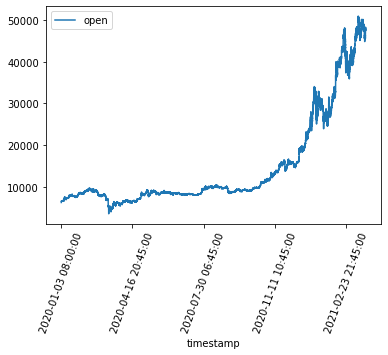

In [45]:
btc.plot(x="timestamp", y="open",rot=70)

In [46]:
data = btc[(btc['timestamp'] > '2021-03-01 00:00:00') ]
data

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
40490,2021-03-01 00:15:00,37706.06,38401.15,37672.96,38268.84,59.363597,1614558599999,2.266480e+06,3019,32.643451,1.246248e+06,0
40491,2021-03-01 00:30:00,38278.45,38600.00,38270.15,38343.60,41.559889,1614559499999,1.598640e+06,2082,26.339773,1.013036e+06,0
40492,2021-03-01 00:45:00,38342.03,38487.66,38253.06,38326.84,19.732699,1614560399999,7.570162e+05,1299,9.807765,3.761798e+05,0
40493,2021-03-01 01:00:00,38328.69,38425.42,38153.23,38220.06,13.811259,1614561299999,5.286249e+05,1050,6.920973,2.648596e+05,0
40494,2021-03-01 01:15:00,38221.98,38316.13,38069.09,38277.22,26.304264,1614562199999,1.004925e+06,1200,11.803032,4.507826e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42752,2021-03-24 15:15:00,47878.68,47934.93,47601.10,47661.35,34.712790,1616599799999,1.657986e+06,3315,16.222685,7.752646e+05,0
42753,2021-03-24 15:30:00,47657.06,47705.39,47411.00,47414.55,50.551049,1616600699999,2.404182e+06,4065,23.406447,1.113508e+06,0
42754,2021-03-24 15:45:00,47414.86,47638.47,47376.40,47589.28,30.414740,1616601599999,1.443908e+06,3152,19.111199,9.074120e+05,0
42755,2021-03-24 16:00:00,47592.68,47700.00,47350.00,47477.14,28.206175,1616602499999,1.340052e+06,3387,15.675022,7.448968e+05,0


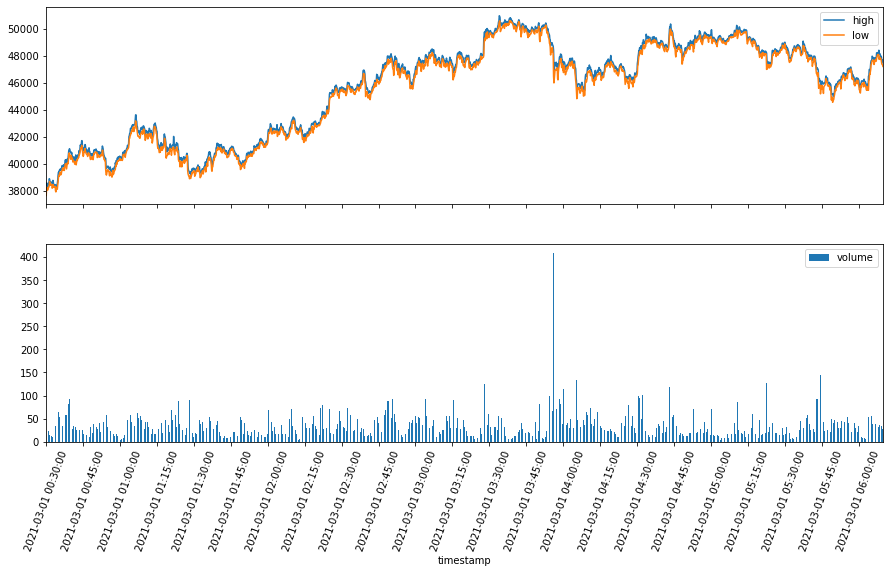

In [47]:

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
data.plot(x="timestamp", y=["high","low"], rot= 70, ax=ax[0])
data.plot.bar(x="timestamp", y="volume", rot= 70, ax=ax[1])
#ax[0].plot(data.timestamp, data.high, rot=70)
#ax[1].bar(data.timestamp, data.volume, width=1/(5*len(data.timestamp)))
#fig.autofmt_xdate()
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(100))
plt.show()